##### Imports

In [1]:
#Reconstruction
#3 factors for potential reconstruction: qc pass, autotrace, ready for dendrite tracing

In [2]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.5)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths/Fields

In [3]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/hl4_plot/")

path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")
path_ephys = os.path.join(csv_path, "ephys_hIVSCC_MET.csv")

In [4]:
ephys_list = ["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", "LS AP up/downstoke", "Latency", "F-I Curve"]
region_list = ["FCx", "OCx", "PCx", "TCx"]

fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]

fields_shiny = ["cell_name", "roi", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label", "seurat_cluster_label",
                "broad_class_label", "subclass_label", "go_no_go_63x", "image_series_63x_qc", "Genes.Detected.CPM"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "Normalized marker sum",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score",
              "go_no_go_63x": "Morpho call(63x)",
              "image_series_63x_qc": "Imaging status",
              "Genes.Detected.CPM": "Genes detected"}

#Replacing string in specific columns
nms_dict = {True: "Pass", False: "Fail"}
morpho_dict = {"63x go": "Go", "63x no go": "No Go"}
imaging_dict = {"ready_for_dendrite_trace": "Ready for dendrite trace", "image_qc_passed": "Image QC passed", 
                "qc": "QC", "deferred": "Deferred", "autotracing": "Autotracing", "rescanning": "Rescanning",
                "processing": "Processing", "failed": "Failed"}

##### Filtering shiny

In [5]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [6]:
shiny_human["NMS Pass/Fail"] = shiny_human["NMS Pass/Fail"].replace(nms_dict)
shiny_human["Morpho call(63x)"] = shiny_human["Morpho call(63x)"].replace(morpho_dict)
shiny_human["Imaging status"] = shiny_human["Imaging status"].replace(imaging_dict)
shiny_human["cDNA quality (%>400 bp)"] = shiny_human["cDNA quality (%>400 bp)"] * 100

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [7]:
shiny_human["region"] = pd.np.where(shiny_human.roi.str.contains("FCx"), "FCx", 
                                    pd.np.where(shiny_human.roi.str.contains("OCx"), "OCx", 
                                    pd.np.where(shiny_human.roi.str.contains("PCx"), "PCx",
                                    pd.np.where(shiny_human.roi.str.contains("TCx"), "TCx", "Unknown/Misc"))))

shiny_human["layer"] = pd.np.where(shiny_human.roi.str.contains("L1"), "L1", 
                                   pd.np.where(shiny_human.roi.str.contains("L2"), "L2",
                                   pd.np.where(shiny_human.roi.str.contains("L3"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L4"), "L4", 
                                   pd.np.where(shiny_human.roi.str.contains("L5"), "L5",
                                   pd.np.where(shiny_human.roi.str.contains("L6"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("L2-3"), "L2-3",
                                   pd.np.where(shiny_human.roi.str.contains("L3a"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3b"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3c"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L6a"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("LL1"), "LL1", 
                                   pd.np.where(shiny_human.roi.str.contains("LL2"), "LL2", 
                                   pd.np.where(shiny_human.roi.str.contains("LL3"), "LL3",
                                   pd.np.where(shiny_human.roi.str.contains("LL4"), "LL4", 
                                   pd.np.where(shiny_human.roi.str.contains("LL5"), "LL5", "unknown_layer"))))))))))))))))

shiny_human["imaging_recon"] = pd.np.where(shiny_human["Imaging status"].str.contains("Ready for dendrite trace"), "Possible Reconstructions", 
                                           pd.np.where(shiny_human["Imaging status"].str.contains("Image QC passed"), "Possible Reconstructions", 
                                           pd.np.where(shiny_human["Imaging status"].str.contains("Autotracing"), "Possible Reconstructions", 
                                           pd.np.where(shiny_human["Imaging status"].str.contains("Deferred"), "Failed Reconstructions", 
                                           pd.np.where(shiny_human["Imaging status"].str.contains("Failed"), "Failed Reconstructions", "In Process")))))

##### Filtering ephys

In [8]:
ephys = read_file(path_ephys, fields_ephys) #1449 rows
ephys.rename(columns={"vrest": "Vm(mV)", 
                      "ri": "Input Resistance(MΩ)",
                      "sag" : "Sag Fraction", 
                      "tau": "τ(s)",
                      "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", 
                      "latency" : "Latency",
                      "f_i_curve_slope" : "F-I Curve"}, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [9]:
ephys

,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
0,H19.03.306.11.15.02.06,-65.122929,185.124964,0.102990,24.413168,3.786294,0.05140,0.165000
1,H18.06.004.11.02.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H18.06.004.11.02.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H18.06.004.11.03.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H19.06.351.11.15.02.01,-60.251895,561.418355,0.015036,37.969562,3.603331,0.03658,0.352966
...,...,...,...,...,...,...,...,...
1444,H20.06.351.11.06.01.04,-65.023605,242.256120,0.161407,23.458603,2.394247,0.02470,0.323529
1445,H20.06.351.11.06.01.05,-65.133683,246.923044,0.077304,21.062437,2.962435,0.02796,0.310000
1446,H20.06.351.11.06.01.06,-69.985204,311.142892,0.071834,23.771703,2.533110,0.02944,0.375000
1447,H20.06.351.11.06.01.08,-61.401253,309.951991,0.213605,17.061975,2.534424,0.02004,0.425000


##### h_l4

In [10]:
h_l4 = filter_df(shiny_human, "layer", "L4")
h_l4.count()

INFO:temp_funcs:Filtered dataframe based on layer == L4


sample_id                  474
cell_name                  474
roi                        474
cDNA quality (%>400 bp)    474
RNA Amp Pass/Fail          474
Amplified content (ng)     474
Genes detected             474
cell_specimen_project      473
Morpho call(63x)           350
Imaging status             138
Normalized marker sum      474
NMS Pass/Fail              474
seurat_cluster_label       474
Seurat prediction score    474
broad_class_label          474
subclass_label             474
Tree_call                  474
region                     474
layer                      474
imaging_recon              474
dtype: int64

##### tcx

In [11]:
tcx = filter_df(h_l4, "region", "TCx") #375 rows
tcx = filter_df(tcx, "RNA Amp Pass/Fail", "Pass") #325 rows
tcx = filter_df(tcx, "NMS Pass/Fail", "Pass") #299 rows

INFO:temp_funcs:Filtered dataframe based on region == TCx
INFO:temp_funcs:Filtered dataframe based on RNA Amp Pass/Fail == Pass
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass


In [12]:
tcx.count()

sample_id                  299
cell_name                  299
roi                        299
cDNA quality (%>400 bp)    299
RNA Amp Pass/Fail          299
Amplified content (ng)     299
Genes detected             299
cell_specimen_project      299
Morpho call(63x)           279
Imaging status             112
Normalized marker sum      299
NMS Pass/Fail              299
seurat_cluster_label       299
Seurat prediction score    299
broad_class_label          299
subclass_label             299
Tree_call                  299
region                     299
layer                      299
imaging_recon              299
dtype: int64

##### Merged tcx with ephys

In [13]:
merged = merge_dataframes(tcx, ephys, "cell_name", "name", "inner") #269 rows
merged.dropna(subset=ephys_list, inplace=True) #240 rows
merged.sort_values(by="seurat_cluster_label", inplace=True)

INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [14]:
merged.count()

sample_id                  240
cell_name                  240
roi                        240
cDNA quality (%>400 bp)    240
RNA Amp Pass/Fail          240
Amplified content (ng)     240
Genes detected             240
cell_specimen_project      240
Morpho call(63x)           229
Imaging status              92
Normalized marker sum      240
NMS Pass/Fail              240
seurat_cluster_label       240
Seurat prediction score    240
broad_class_label          240
subclass_label             240
Tree_call                  240
region                     240
layer                      240
imaging_recon              240
name                       240
Vm(mV)                     240
Input Resistance(MΩ)       240
Sag Fraction               240
τ(s)                       240
LS AP up/downstoke         240
Latency                    240
F-I Curve                  240
dtype: int64

##### Seurat list with greater than 5 datapoints

In [15]:
seurat_list =[]
for n in merged["seurat_cluster_label"].unique():
        value = merged[merged["seurat_cluster_label"] == n]["Vm(mV)"].count() >= 5
        if value == True:
            seurat_list.append(n)
seurat_sorted_list = sorted(seurat_list)
seurat_sorted_list

['Exc L2-4 LINC00507 GLP2R',
 'Exc L3-5 RORB COL22A1',
 'Exc L3-5 RORB ESR1',
 'Exc L3-5 RORB TWIST2',
 'Exc L4-5 RORB DAPK2',
 'Exc L4-5 RORB FOLH1B',
 'Exc L4-6 RORB SEMA3E',
 'Inh L2-4 PVALB WFDC2',
 'Inh L4-6 PVALB SULF1']

In [16]:
subclass_list =[]
for n in merged["subclass_label"].unique():
        value = merged[merged["subclass_label"] == n]["Vm(mV)"].count() >= 5
        if value == True:
            subclass_list.append(n)
subclass_sorted_list = sorted(subclass_list)
subclass_sorted_list

['IT (L2-3)', 'IT (L3-5)', 'IT (L4-6)', 'PVALB', 'SST']

##### Plot Colors

In [17]:
ei_seurat_colors=["#67000d", "#a50f15", "#cb181d", "#ef3b2c", "#fb6a4a", "#fc9272", "#fcbba1", "#fee0d2", 
                  "#3182bd", "#9ecae1"]
ei_subclass_colors=["#cb181d", "#fb6a4a", "#fcae91",
                    "#2171b5", "#6baed6", "#bdd7e7"]
gn_colors={"Go": "#41ab5d", "No Go": "#ef3b2c"}
tree_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

##### Clustered Boxplot for TCx

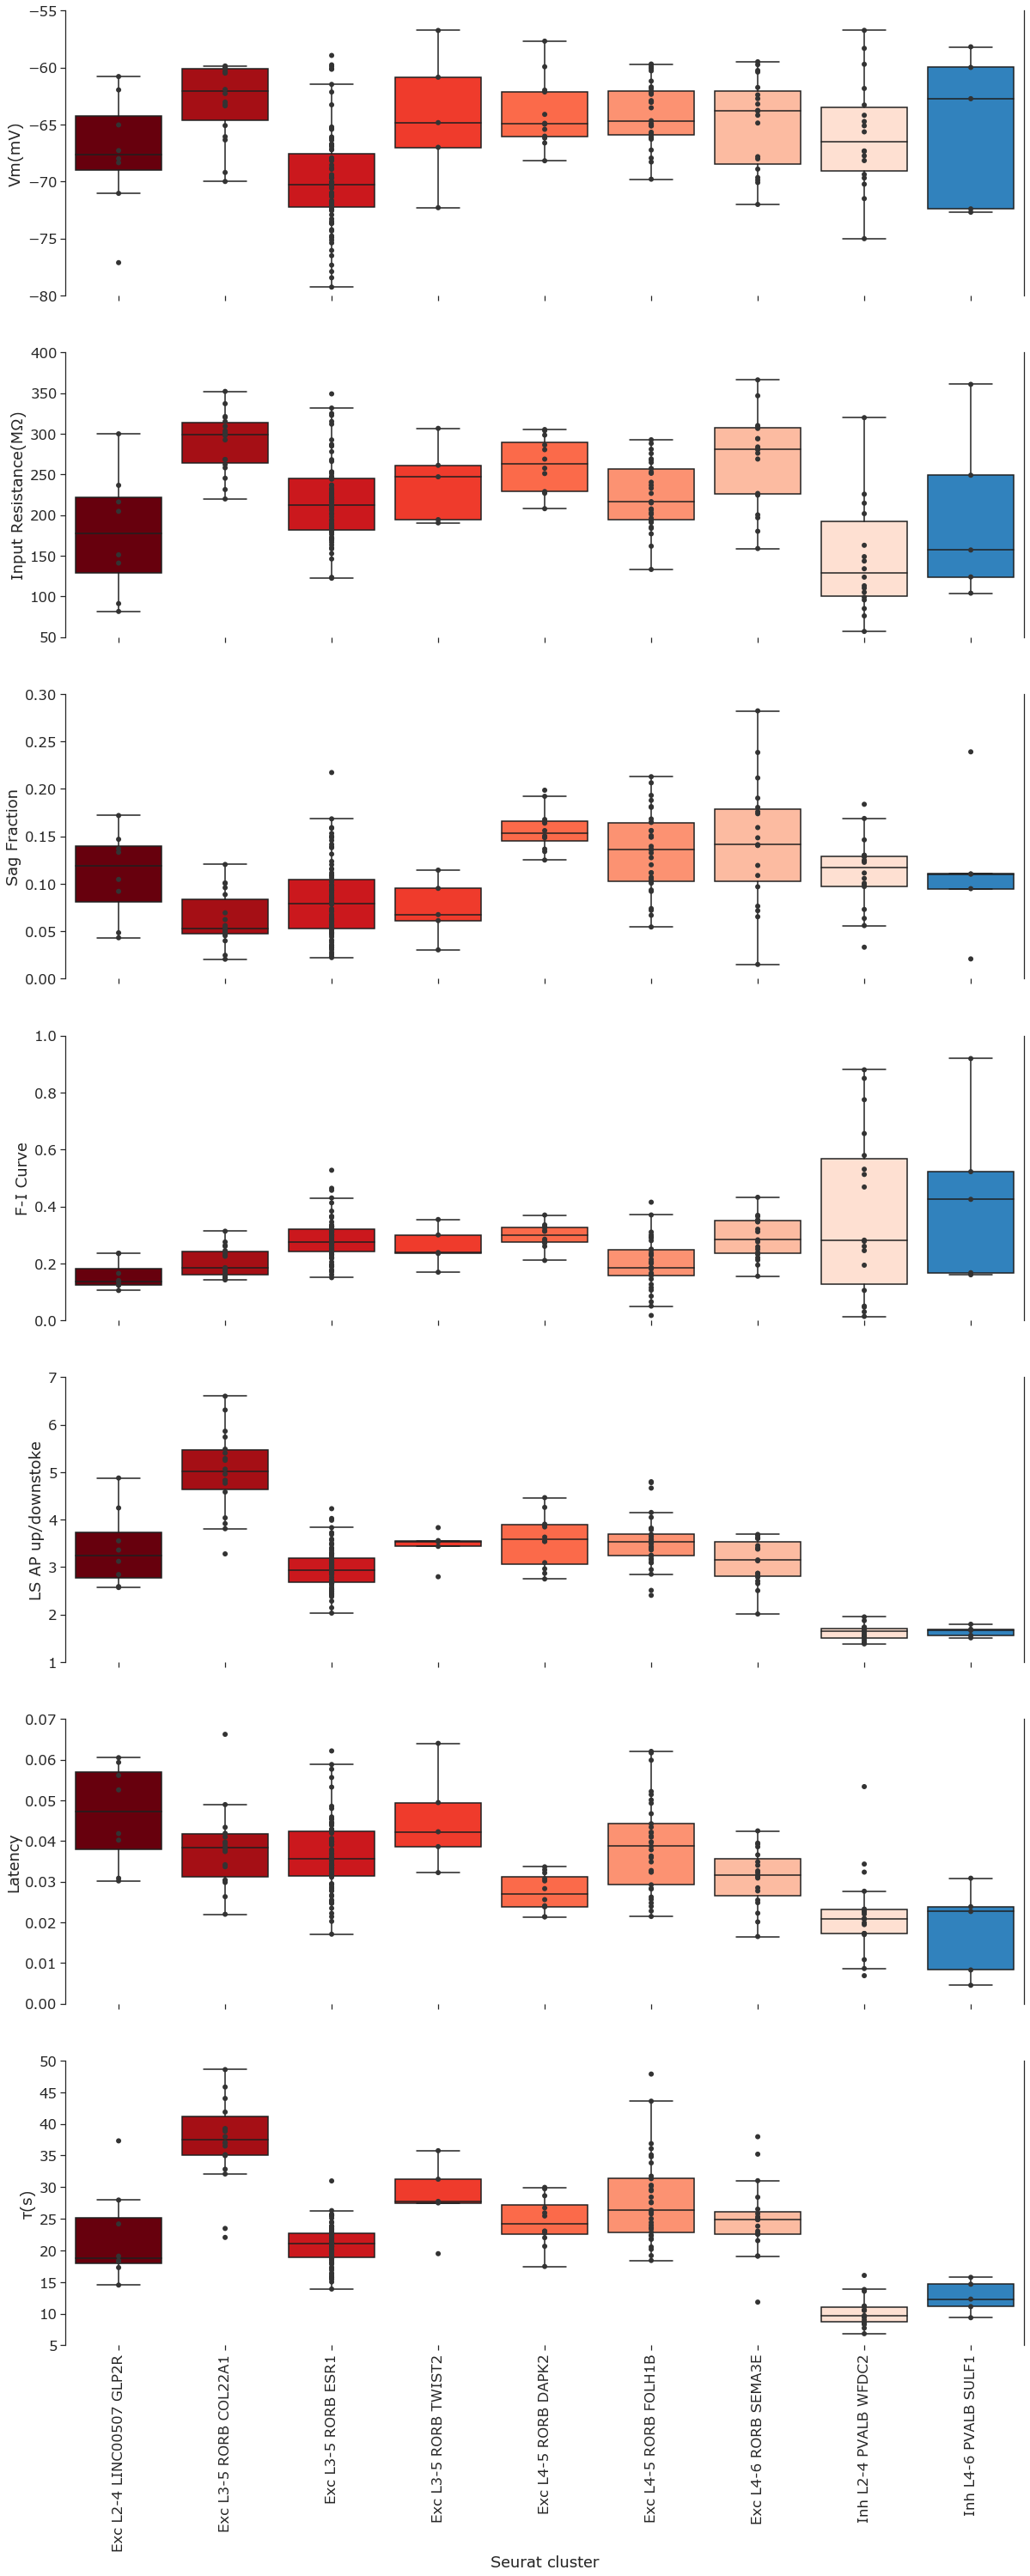

In [18]:
f, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 50))

ax = sns.boxplot(x="seurat_cluster_label", y="Vm(mV)", data=merged, order=seurat_sorted_list, 
                 showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[0])
ax = sns.stripplot(x="seurat_cluster_label", y="Vm(mV)", data=merged, order=seurat_sorted_list,
                   color="0.2", size=6, jitter=False, ax=axes[0])

ax1 = sns.boxplot(x="seurat_cluster_label", y="Input Resistance(MΩ)", data=merged, order=seurat_sorted_list, 
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[1])
ax1 = sns.stripplot(x="seurat_cluster_label", y="Input Resistance(MΩ)", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[1])

ax2 = sns.boxplot(x="seurat_cluster_label", y="Sag Fraction", data=merged, order=seurat_sorted_list,
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[2])
ax2 = sns.stripplot(x="seurat_cluster_label", y="Sag Fraction", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[2])

ax3 = sns.boxplot(x="seurat_cluster_label", y="F-I Curve", data=merged, order=seurat_sorted_list,
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[3])
ax3 = sns.stripplot(x="seurat_cluster_label", y="F-I Curve", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[3])

ax4 = sns.boxplot(x="seurat_cluster_label", y="LS AP up/downstoke", data=merged, order=seurat_sorted_list,
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[4])
ax4 = sns.stripplot(x="seurat_cluster_label", y="LS AP up/downstoke", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[4])

ax5 = sns.boxplot(x="seurat_cluster_label", y="Latency", data=merged, order=seurat_sorted_list, 
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[5])
ax5 = sns.stripplot(x="seurat_cluster_label", y="Latency", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[5])

ax6 = sns.boxplot(x="seurat_cluster_label", y="τ(s)", data=merged, order=seurat_sorted_list,
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[6])
ax6 = sns.stripplot(x="seurat_cluster_label", y="τ(s)", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[6])

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Seurat cluster")
sns.despine(bottom=True, right=False)

ax.set(ylim=(-80, -55))
ax1.set(ylim=(50, 400))
ax2.set(ylim=(0, 0.3))
ax3.set(ylim=(0, 1))
ax4.set(ylim=(1, 7))
ax5.set(ylim=(0, 0.07))
ax6.set(ylim=(5, 50))

plt.xticks(rotation=90)
plt.savefig(plot_path + "tcx_seurat_bxplot.jpeg", bbox_inches="tight")

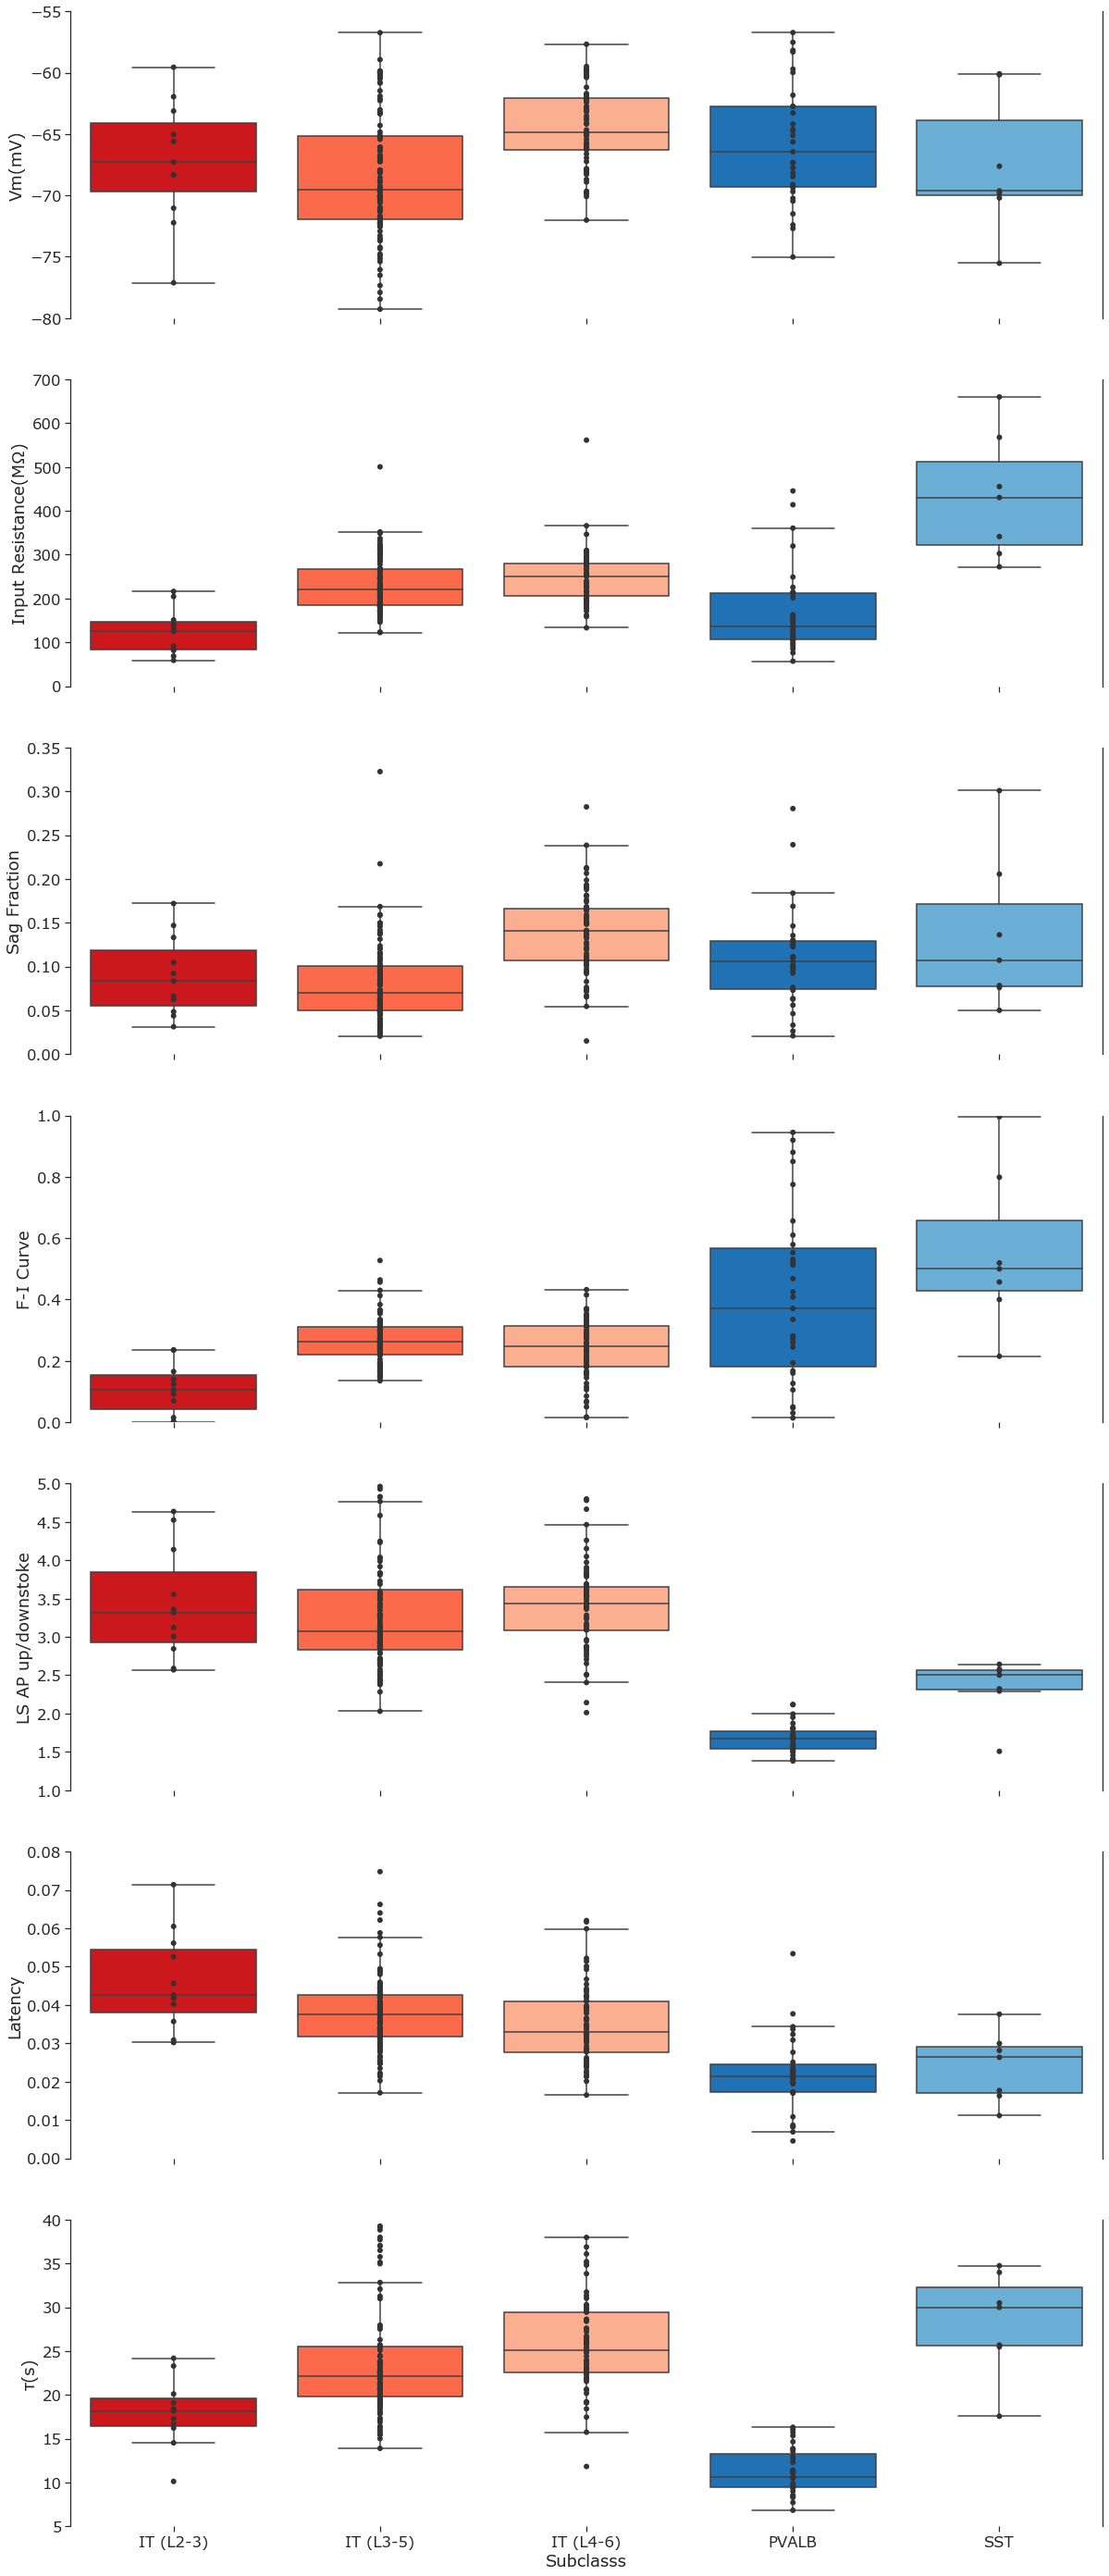

In [19]:
f, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 50))

ax = sns.boxplot(x="subclass_label", y="Vm(mV)", data=merged, order=subclass_sorted_list, 
                 showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[0])
ax = sns.stripplot(x="subclass_label", y="Vm(mV)", data=merged, order=subclass_sorted_list,
                   color="0.2", size=6, jitter=False, ax=axes[0])

ax1 = sns.boxplot(x="subclass_label", y="Input Resistance(MΩ)", data=merged, order=subclass_sorted_list, 
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[1])
ax1 = sns.stripplot(x="subclass_label", y="Input Resistance(MΩ)", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[1])

ax2 = sns.boxplot(x="subclass_label", y="Sag Fraction", data=merged, order=subclass_sorted_list,
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[2])
ax2 = sns.stripplot(x="subclass_label", y="Sag Fraction", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[2])

ax3 = sns.boxplot(x="subclass_label", y="F-I Curve", data=merged, order=subclass_sorted_list,
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[3])
ax3 = sns.stripplot(x="subclass_label", y="F-I Curve", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[3])

ax4 = sns.boxplot(x="subclass_label", y="LS AP up/downstoke", data=merged, order=subclass_sorted_list,
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[4])
ax4 = sns.stripplot(x="subclass_label", y="LS AP up/downstoke", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[4])

ax5 = sns.boxplot(x="subclass_label", y="Latency", data=merged, order=subclass_sorted_list, 
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[5])
ax5 = sns.stripplot(x="subclass_label", y="Latency", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[5])

ax6 = sns.boxplot(x="subclass_label", y="τ(s)", data=merged, order=subclass_sorted_list,
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[6])
ax6 = sns.stripplot(x="subclass_label", y="τ(s)", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[6])

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Subclasss")
sns.despine(bottom=True, right=False)

ax.set(ylim=(-80, -55))
ax1.set(ylim=(0, 700))
ax2.set(ylim=(0, 0.35))
ax3.set(ylim=(0, 1))
ax4.set(ylim=(1, 5))
ax5.set(ylim=(0, 0.08))
ax6.set(ylim=(5, 40))

plt.xticks(rotation=0)
plt.savefig(plot_path + "tcx_subclass_bxplot.jpeg", bbox_inches="tight")

##### Gate 1: 63x go vs 63x no go (RNA Amp & NMS PASS ONLY)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

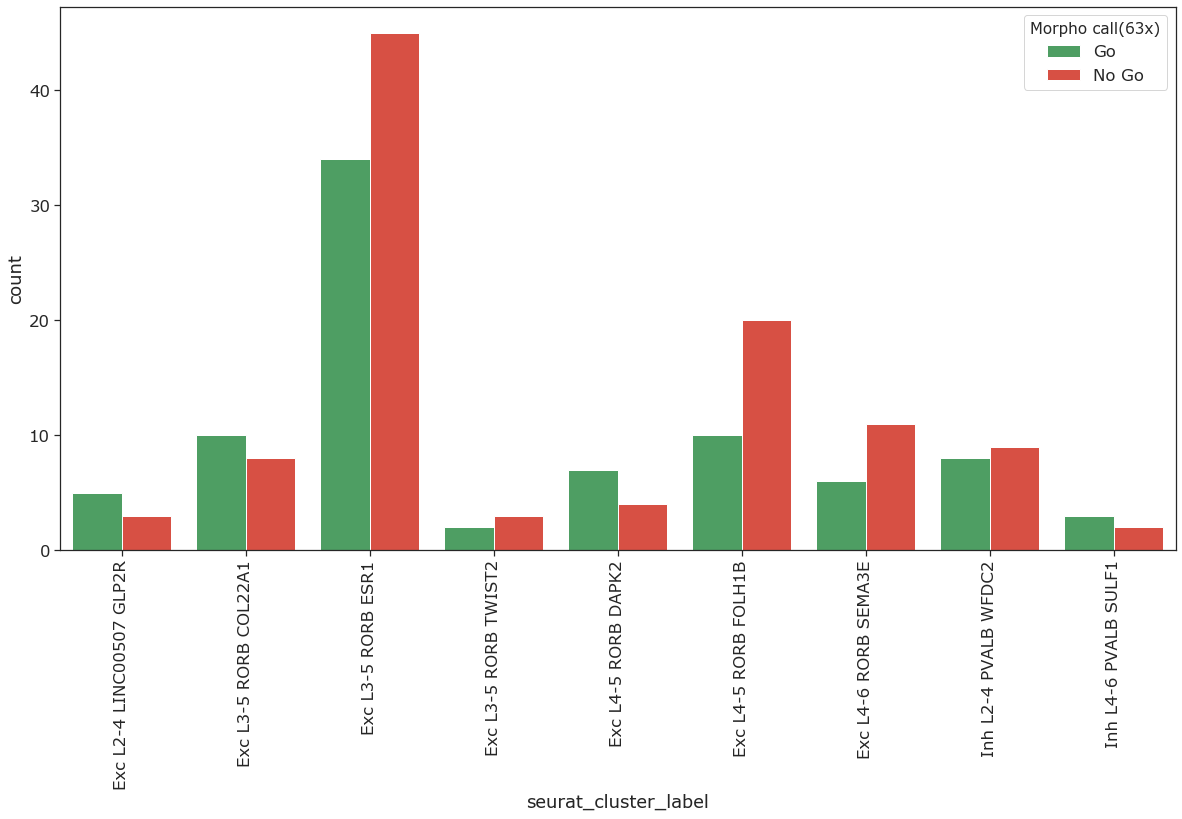

In [20]:
f, axes = plt.subplots(figsize=(20, 10))
gate_1 = sns.countplot(x="seurat_cluster_label", order=seurat_sorted_list, hue="Morpho call(63x)", data=merged,
              palette=gn_colors)
plt.xticks(rotation=90)

In [21]:
# 2nd gate --> QC, 

In [22]:
# 3rd 

In [23]:
#3rd gate
# Possible Reconstructions: Image QC passed, Autotracing, Ready for dendrite trace
# Failed: Deferred, Failed

In [24]:
imaging_status_list = ["Ready for dendrite trace", "Autotracing", "Image QC passed",
                       "Deferred", "Failed",
                       "QC", 
                       "Rescanning", "Processing"]
imaging_final_gate_list = ["Ready for dendrite trace", "Autotracing", "Image QC passed", "Deferred", "Failed"]
image_recon_list = ["Possible Reconstructions", "Failed Reconstructions", "In Process"]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

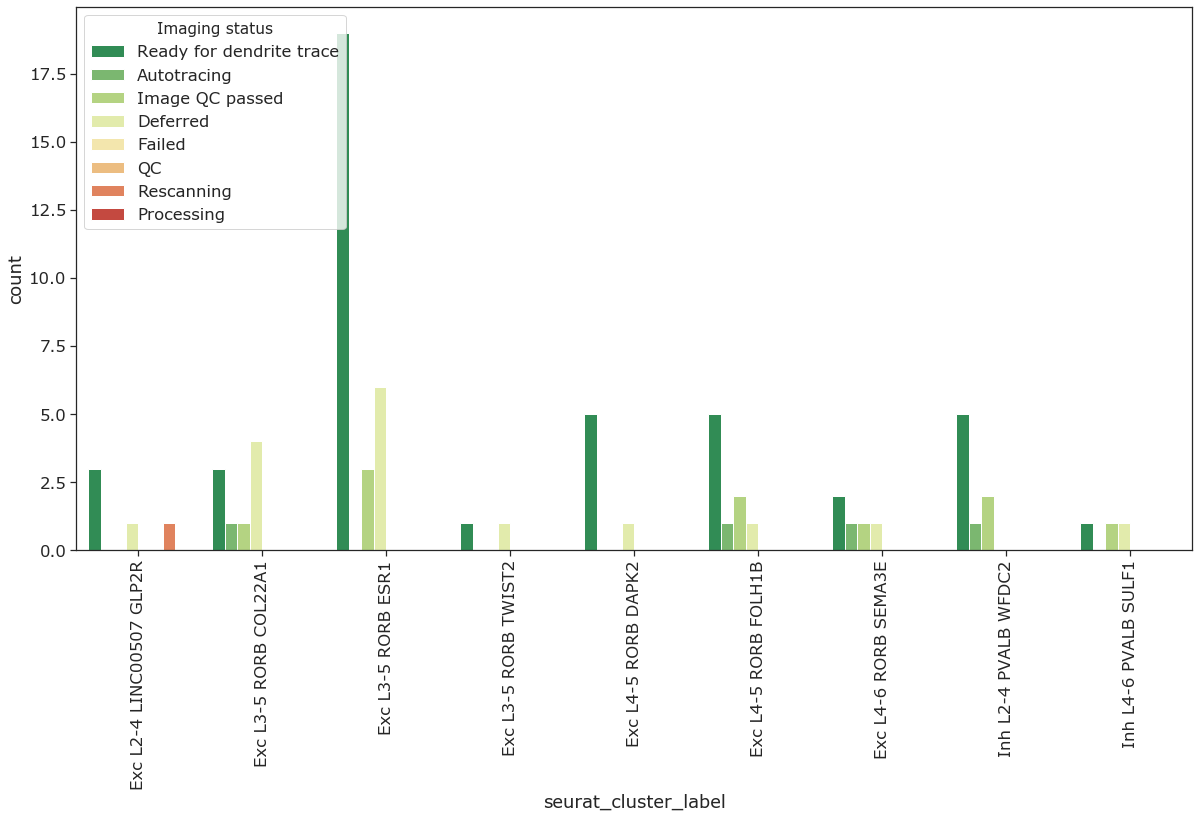

In [53]:
f, axes = plt.subplots(figsize=(20, 10))
sns.countplot(x="seurat_cluster_label", order=seurat_sorted_list, hue="Imaging status", hue_order=imaging_status_list,
              data=merged, palette="RdYlGn_r")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

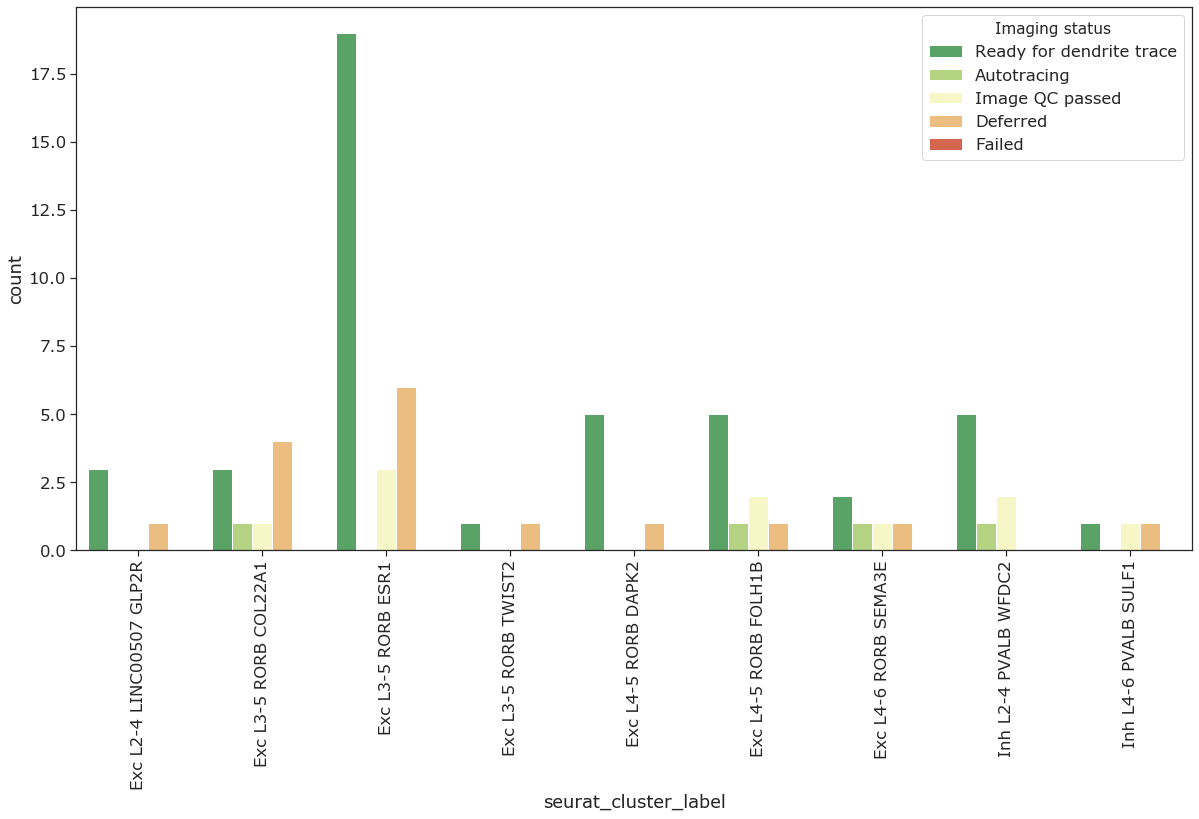

In [52]:
f, axes = plt.subplots(figsize=(20, 10))
sns.countplot(x="seurat_cluster_label", order=seurat_sorted_list, hue="Imaging status", hue_order=imaging_final_gate_list,
              data=merged, palette="RdYlGn_r")
plt.xticks(rotation=90)

In [75]:
image_precon_list = {"Possible Reconstructions": "#31a354"}

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

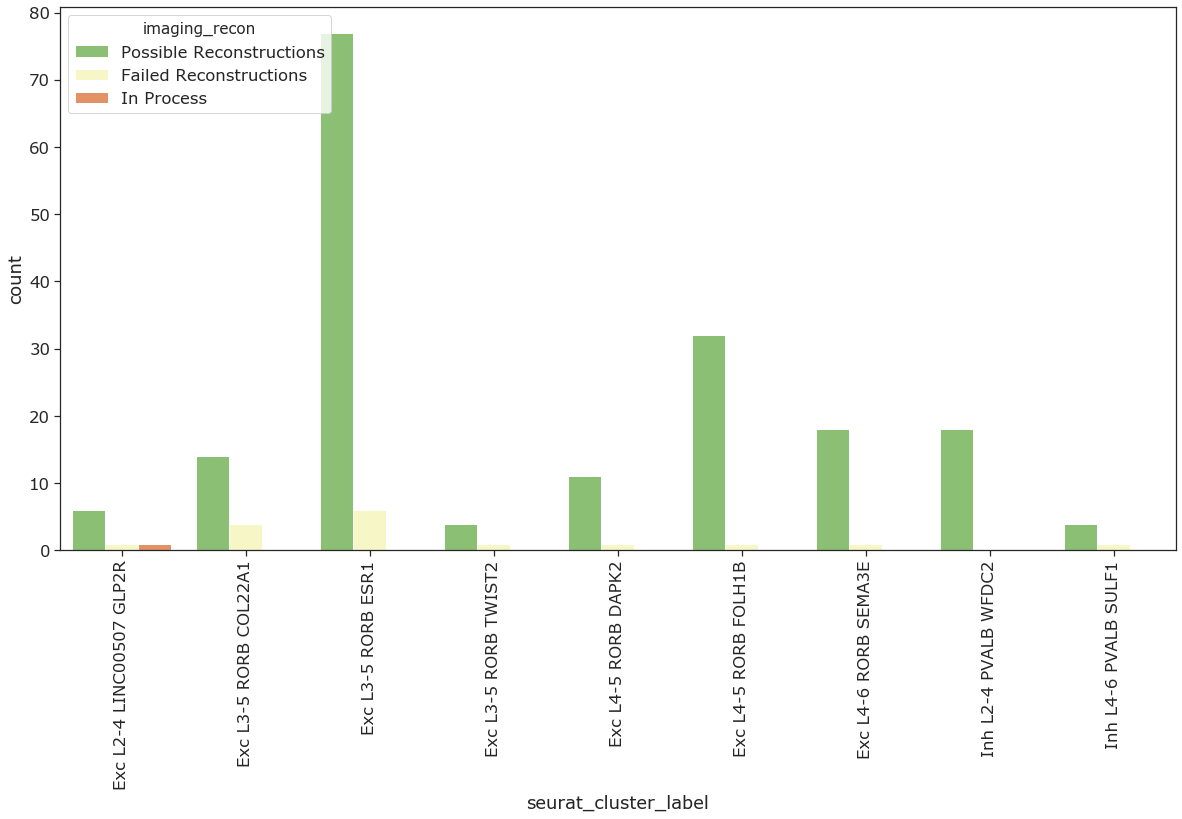

In [55]:
f, axes = plt.subplots(figsize=(20, 10))
sns.countplot(x="seurat_cluster_label", order=seurat_sorted_list, hue="imaging_recon", hue_order=image_recon_list,
              data=merged, palette="RdYlGn_r")
plt.xticks(rotation=90)

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <a list of 10 Text xticklabel objects>)

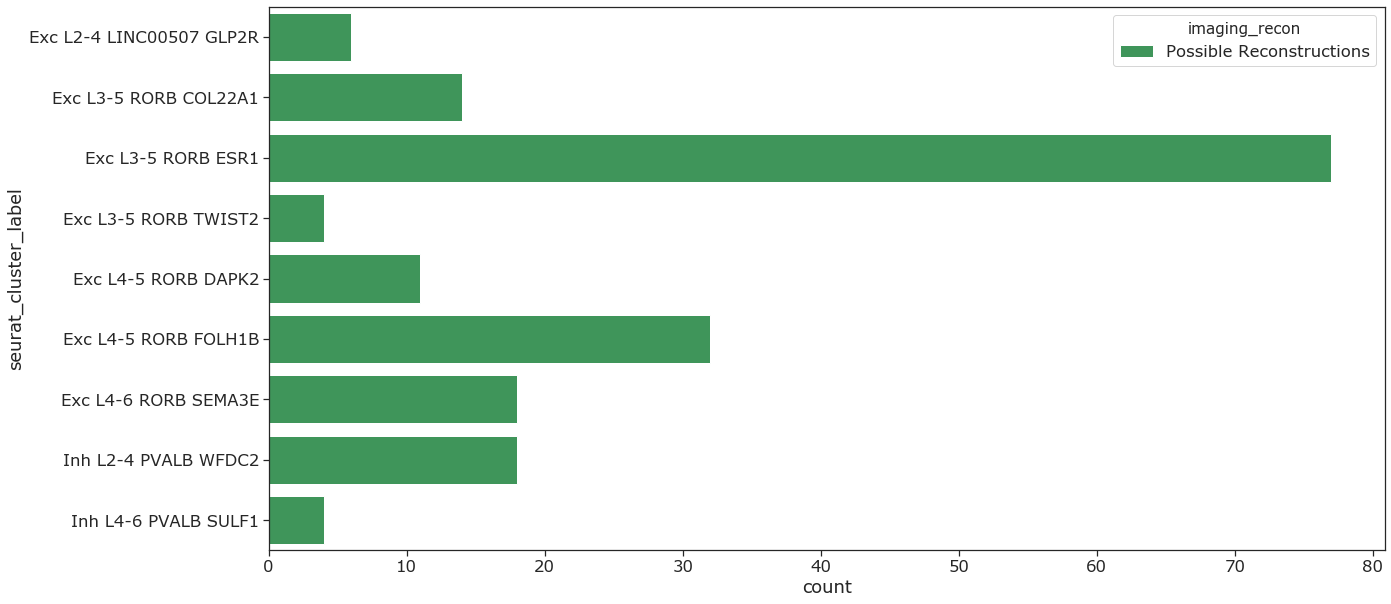

In [78]:
f, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y="seurat_cluster_label", order=seurat_sorted_list, hue="imaging_recon", hue_order=image_precon_list,
              data=merged, palette=image_precon_list)
plt.xticks(rotation=0)

In [29]:
merged

,sample_id,cell_name,roi,cDNA quality (%>400 bp),RNA Amp Pass/Fail,Amplified content (ng),Genes detected,cell_specimen_project,Morpho call(63x),Imaging status,Normalized marker sum,NMS Pass/Fail,seurat_cluster_label,Seurat prediction score,broad_class_label,subclass_label,Tree_call,region,layer,imaging_recon,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
38,PBS4_180221_503_A01,H18.03.003.12.01.03,TCx_L4,64.5,Pass,18.861931,10408,hIVSCC-MET,Go,Deferred,0.819991,Pass,Exc L2 LAMP5 LTK,0.756974,Glutamatergic neuron,IT (L2-3),I1,TCx,L4,Failed Reconstructions,H18.03.003.12.01.03,-65.597712,132.812500,0.043755,20.105331,3.005856,0.04174,9.184211e-02
42,P2S4_180816_052_A01,H18.06.363.11.15.02.02,TCx_L4,71.8,Pass,111.516130,14557,hIVSCC-MET,Go,Ready for dendrite trace,0.795725,Pass,Exc L2-3 LINC00507 FREM3,0.933551,Glutamatergic neuron,IT (L2-3),I1,TCx,L4,Possible Reconstructions,H18.06.363.11.15.02.02,-63.121653,124.687389,0.062476,23.296120,4.139188,0.07136,3.133903e-03
226,PBS4_180508_512_A01,H18.03.010.11.11.06,TCx_L4,70.3,Pass,41.118285,14084,hIVSCC-MET,No Go,NaN,0.896680,Pass,Exc L2-3 LINC00507 FREM3,0.731021,Glutamatergic neuron,IT (L2-3),I1,TCx,L4,Possible Reconstructions,H18.03.010.11.11.06,-68.326581,68.593748,0.065892,16.221210,4.523450,0.04252,6.935484e-02
43,P8S4_190108_362_A01,H19.03.301.11.12.01.05,TCx_L4,66.9,Pass,25.304321,15365,hIVSCC-MET,No Go,NaN,0.910356,Pass,Exc L2-3 LINC00507 FREM3,0.419836,Glutamatergic neuron,IT (L2-3),I1,TCx,L4,Possible Reconstructions,H19.03.301.11.12.01.05,-72.229640,84.435098,0.083544,10.121883,3.316152,0.03568,-2.014430e-18
41,P2S4_181127_057_A01,H18.03.322.11.10.01.09,TCx_L4,65.7,Pass,30.636354,14993,hIVSCC-MET,Go,Deferred,0.993926,Pass,Exc L2-3 LINC00507 FREM3,0.997559,Glutamatergic neuron,IT (L2-3),Core,TCx,L4,Failed Reconstructions,H18.03.322.11.10.01.09,-59.553027,58.759160,0.031299,16.721216,4.635727,0.04560,1.500000e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,PFS4_190514_709_A01,H19.03.311.14.09.01.03,TCx_L4,36.9,Pass,15.995120,8908,hIVSCC-MET,No Go,NaN,1.016964,Pass,Inh L4-6 SST B3GAT2,0.631797,GABAergic neuron,SST,I1,TCx,L4,Possible Reconstructions,H19.03.311.14.09.01.03,-69.637448,659.993649,0.136166,29.987529,2.557775,0.01630,5.000000e-01
212,P8S4_190514_356_A01,H19.03.311.14.05.01.05,TCx_L4,53.9,Pass,11.521796,7918,hIVSCC-MET,Go,Image QC passed,1.170152,Pass,Inh L4-6 SST B3GAT2,0.815097,GABAergic neuron,SST,I2,TCx,L4,Possible Reconstructions,H19.03.311.14.05.01.05,-70.205626,567.845345,0.075989,33.975722,2.323413,0.02994,4.571429e-01
8,P8S4_190709_359_A01,H19.03.315.11.01.01.03,TCx_L4,60.8,Pass,24.981095,9540,hIVSCC-MET,No Go,NaN,0.760139,Pass,Inh L4-6 SST GXYLT2,0.805382,GABAergic neuron,SST,Core,TCx,L4,Possible Reconstructions,H19.03.315.11.01.01.03,-60.167358,455.456644,0.050051,34.739334,2.501881,0.01768,5.192308e-01
7,PFS4_190514_707_A01,H19.03.311.14.09.01.01,TCx_L4,62.6,Pass,22.534484,11298,hIVSCC-MET,No Go,NaN,0.910007,Pass,Inh L4-6 SST GXYLT2,0.788271,GABAergic neuron,SST,Core,TCx,L4,Possible Reconstructions,H19.03.311.14.09.01.01,-69.826057,272.358090,0.078348,30.489864,2.643012,0.03758,2.150000e-01


##### Seurat cluster plots

[(25, 85)]

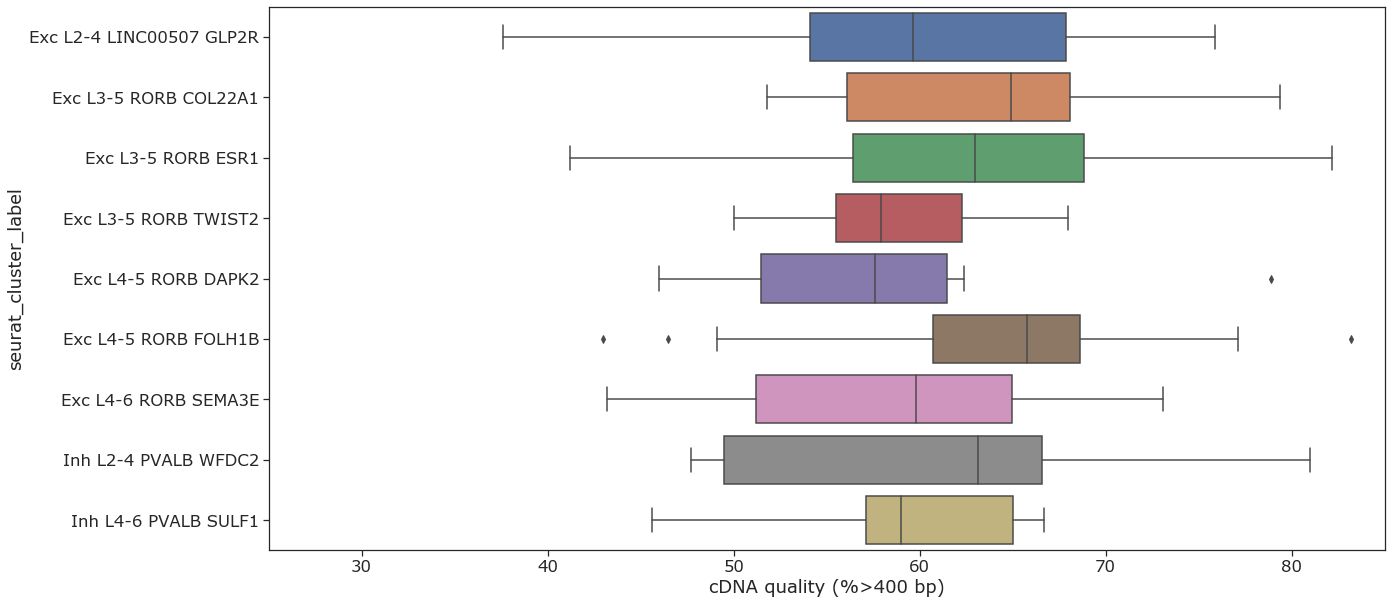

In [30]:
f, axes = plt.subplots(figsize=(20,10))
ax=sns.boxplot(y="seurat_cluster_label", x="cDNA quality (%>400 bp)", order=seurat_sorted_list, data=merged, orient="h")
plt.xticks(rotation=0)
ax.set(xlim=(25, 85))

[(6000, 16000)]

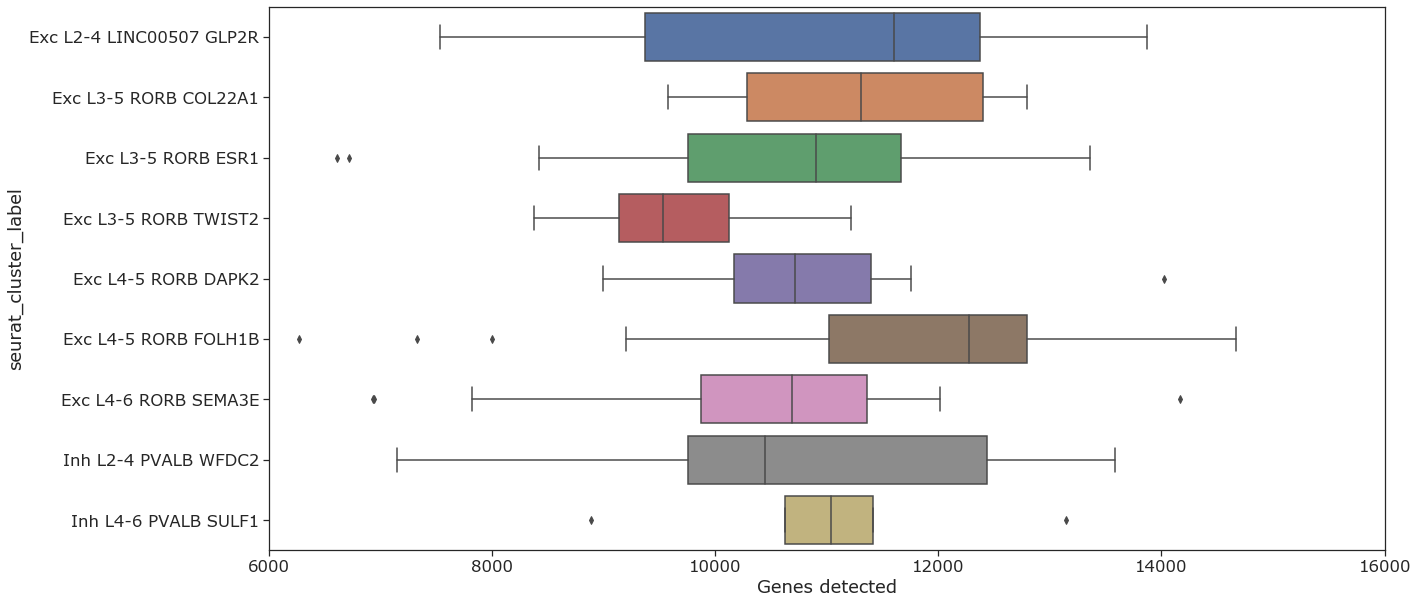

In [31]:
f, axes = plt.subplots(figsize=(20,10))
ax=sns.boxplot(y="seurat_cluster_label", x="Genes detected", order=seurat_sorted_list, data=merged, orient="h")
plt.xticks(rotation=0)
ax.set(xlim=(6000, 16000))

[(0, 120)]

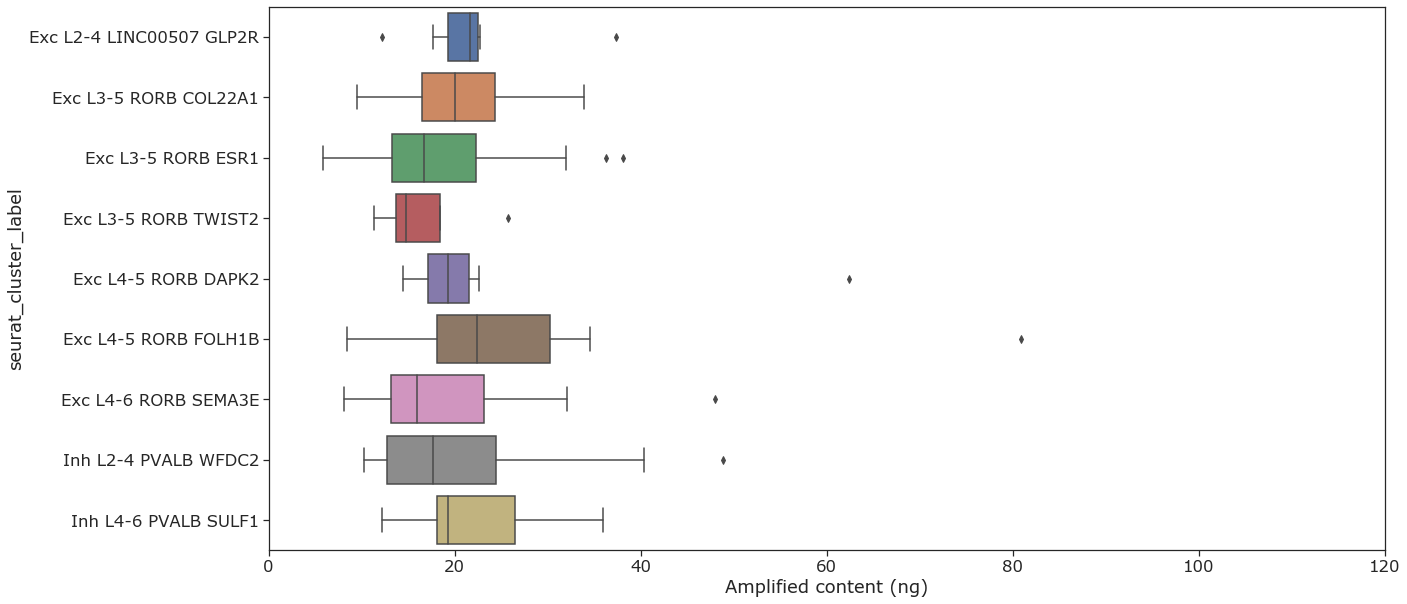

In [32]:
f, axes = plt.subplots(figsize=(20,10))
ax=sns.boxplot(y="seurat_cluster_label", x="Amplified content (ng)", order=seurat_sorted_list, data=merged, orient="h")
plt.xticks(rotation=0)
ax.set(xlim=(0, 120))

(array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3]),
 <a list of 11 Text xticklabel objects>)

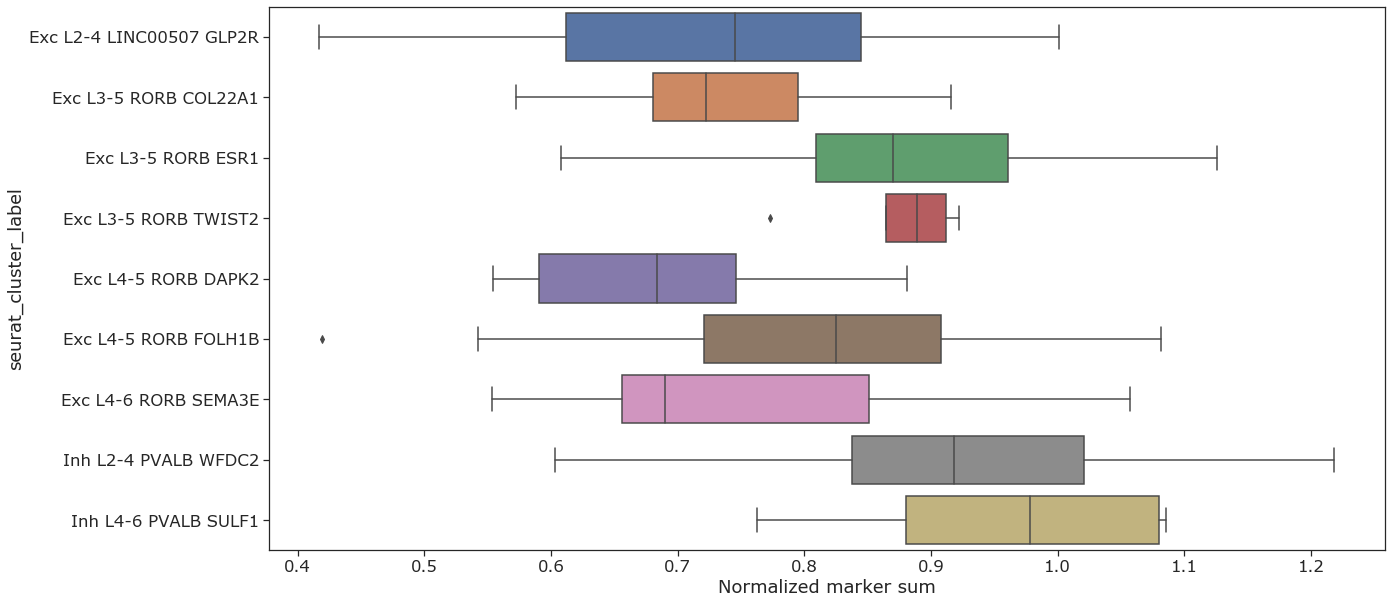

In [33]:
f, axes = plt.subplots(figsize=(20,10))
ax=sns.boxplot(y="seurat_cluster_label", x="Normalized marker sum", order=seurat_sorted_list, data=merged, orient="h")
plt.xticks(rotation=0)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 11 Text xticklabel objects>)

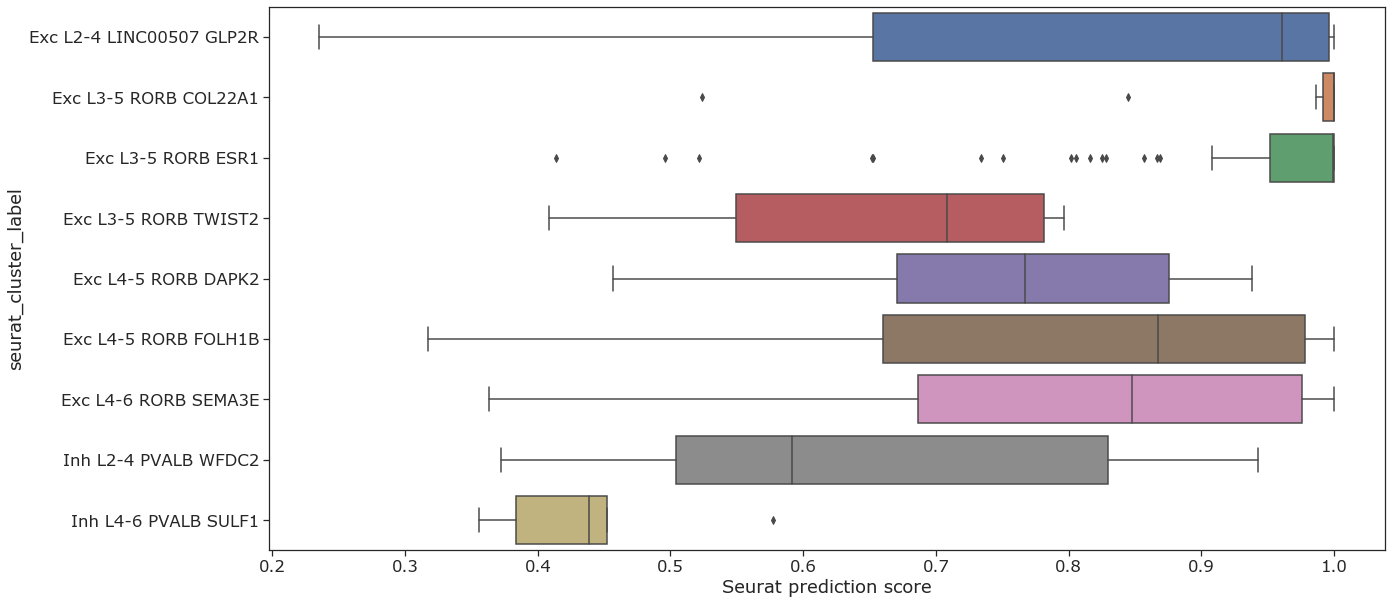

In [34]:
f, axes = plt.subplots(figsize=(20,10))
ax=sns.boxplot(y="seurat_cluster_label", x="Seurat prediction score", order=seurat_sorted_list, data=merged, orient="h")
plt.xticks(rotation=0)

##### Tree call Plots

[(20, 90)]

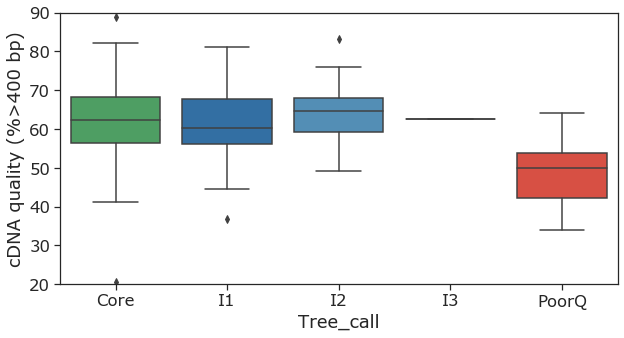

In [35]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="cDNA quality (%>400 bp)", data=merged, palette=tree_colors, order=tree_colors)
ax.set(ylim=(20, 90))

[(2000, 16000)]

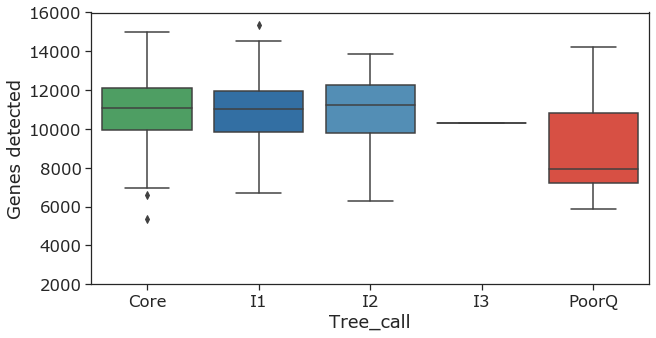

In [36]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="Genes detected", data=merged, palette=tree_colors, order=tree_colors)
ax.set(ylim=(2000,16000))

[(0, 45)]

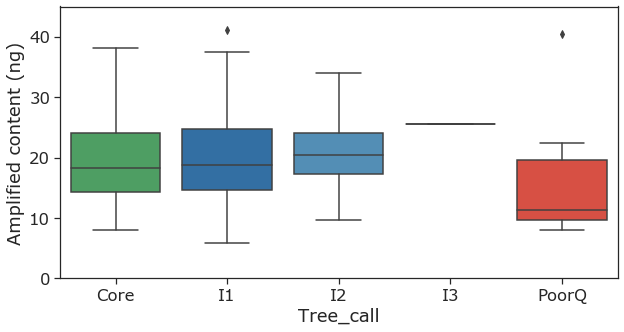

In [37]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="Amplified content (ng)", data=merged, palette=tree_colors, order=tree_colors)
ax.set(ylim=(0, 45))

[(0.4, 1.3)]

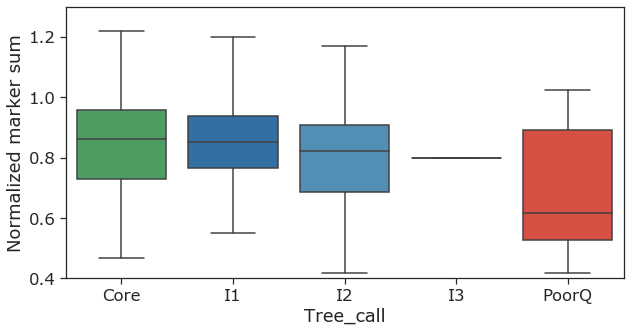

In [38]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="Normalized marker sum", data=merged, palette=tree_colors, order=tree_colors)
ax.set(ylim=(0.4, 1.3))

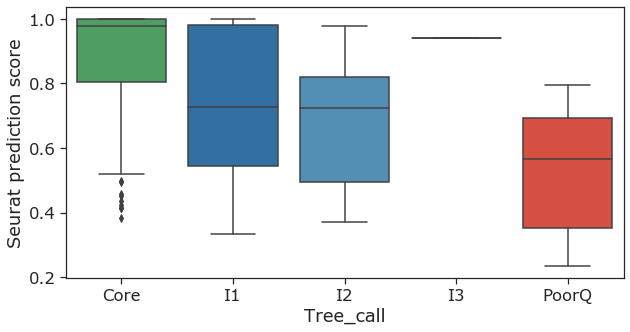

In [39]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="Seurat prediction score", data=merged, palette=tree_colors, order=tree_colors)